Name, UID: Disa Alda Naomi, XXXXXXXXX

In [1]:
from __future__ import print_function
import time

# Math 164 Optimization Challenge

# Maximum Flow - Minimal Cut : The Assignment Problem

## Background

The optimization methods that we learned in class can be utilized to solve allocation problems, or more generally, to maximize or minimize resources given various constraints and objectives in mind. I am particularly interested in how real-life problems can be formulated and solved through different mathematical tools. 

During discussion we had an exercise to solve a maximum flow minimial cut problem, which I was really interested with. I thought it was really cool to represent a linear program in graphs. After more research and reading on applications of the maximum flow and minimal cut problem, I thought the assignment problem is a useful application to determine the assignment that allocates the most optimal resources. For this project, I wanted to take an example of its application in assigning fastest pick-ups to uber drivers.

### Application: Assigning Fastest Pick-Ups to Uber Drivers

Everybody hates waiting for Ubers. To explore the methods, let's start with a relatable narrative: We can formulate the assignment of **Uber drivers** (workers) to nearby **pick-ups** (jobs) as a minimization of **waiting time** (objective function) derived from how far, in minutes, the drivers are to pick-ups (cost). Say it's UberX (or Uber Black) so each driver can only complete one pick up at a time, and the riders can only be picked up once. For this problem, we focus on solving the case where there are equal numbers of drivers and pick-ups, which is the suggested formulation of assingment problem to solve when using the packages in consideration.

Formulating the problem as a standard linear program below, we explore three methods using networkx's Maximum Bipartite Graph Matching and Google OR Tools' Linear Sum Assignment and Minimum Cost Flow. We then compare the runtime of the method for different scales of the problem i.e. different numbers of drivers and pick-ups at each iteration.

## Linear Program Formulation

### Maximum Flow Minimum Cut

Suppose $G = (V, E)$ be a directed graph, and let $c_{ij}$ be the maximum flow that can be pushed from vertex $i$ to $j$. We want to maximize the total flow from a given source node $s$ to a target node $t$ ($ s \neq t$), while maintaining equal inflow and outflow at every intermediate node.

A **flow $f_{vw}$** is an assigment of weights to edges $v$ and $w$. Flow of an edge must be within its **capacity**, as nodes should only be able to transfer materials less than or equal to its capacity. 

This results in a maximization problem: $$ {\mathrm max} \sum_{j=1} f_{sj}$$
Subject to 
Flow Conservation: $$ \forall v \in V \ {s, t}: \sum_{w \in V} f_{wv} = \sum_{w \in V} f_{vw} $$
Non-negativity: $$ \forall v, w \in V : f_{vw} \geq 0 $$
Capacity: $$ \forall v,w \in V :  f_{vw} \leq c_{vw} $$


### The Assignment Problem

A version of the problem above is the task of assigning $n$ jobs to $m$ machines/workers. Let $x_{i,j} = 1$  if job $j$ is assigned to worker $i$, $0$ if job $j$ is not assigned to worker $i$. Each person can only work on one job and one job can only be worked on by one person, with its respective costs $c_{i,j}$. We want to minimize the cost of completing all of our jobs using all of our resources. 

This results in a minimization problem: $$ {\mathrm min} \sum_{i=1}^{n}\sum_{j=1}^{n} c_{ij}x_{ij}$$
Subject to: 
$$$$
Each worker is assigned one job : $$ i = 1,...,m \sum_{i=1}^{m} x_{ij} = 1 $$
Each job is assigned one worker : $$ j = 1,...,n \sum_{j=1}^{n} x_{ij} = 1 $$
A worker can only work a job at a time:  $x_{ij} = 0 $  or  $1 $ 
 as well as nonnegative cost/waiting time $ c_{i,j} \geq 0 $ 

We can match the Max Flow Min Cut problem by adding sink and source nodes that denote the total number of jobs completed in the network. This illustrates flow conservation as total resources from source i.e. number of workers need to match total outputs i.e. total number of jobs.

## Implementation

We generate the data of waiting times between drivers and pick-ups randomly. For this problem we assume that the waiting time vary, in integers, between 1 and 30 minutes. We should keep in mind that waiting times would fluctuate depending on area, supply of drivers and pick-up demands, and so might not be 'random'.

### Generate Random Data 

In [2]:
import random 

def generate_data(totalnodes, drivers, pickups):
    random.seed(1)
    totaledges = drivers * pickups # without edges to/from source and sink 

    start_nodes= [0]*drivers 
    for d in range(1,drivers+1):
        for p in range(pickups):
            start_nodes.append(d)
    for p in range(1,pickups+1):
        start_nodes.append(drivers+p)
    #print(start_nodes)

    end_nodes = []
    for d in range(1,drivers+1):
        end_nodes.append(d)
    for d in range(1,drivers+1): 
        for p in range(1, pickups+1):
            end_nodes.append(drivers+p)
        
    end_nodes += [(totalnodes-1)]*pickups
    #print(end_nodes)

    capacities = [1]*(totaledges + drivers + pickups)
    #print(capacities)

    costs = [[0]*drivers]
    for d in range(drivers):
        temp = []
        for j in range(pickups):
            temp.append(random.randint(1,30))
        costs.append(temp)
    costs.append([0]*pickups)

    #print(costs) # costs is a matrix here
    return start_nodes, end_nodes, capacities, costs

First, to illustrate the problem, we start with a problem that only involves four drivers and four pick-ups in the area.

In [3]:
drivers = 4
pickups = 4
totalnodes= drivers + pickups + 2

In [4]:
start_nodes, end_nodes, capacities, costs = generate_data(totalnodes, drivers, pickups)

### Visualizing the Problem as a Graph

In [27]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt

The network of Uber drivers and pick-ups can be represented by a **bipartite graph**. A Bipartite Graph $G(V,E)$ is a graph where $ V = X \cup Y $, $X$ and $Y$ are disjoint and $ E \subseteq X x Y $.  We represent drivers and pick-ups as nodes, connected by an edge if they are nearby with waiting time as an attribute of the edge. Here $X$ is the set of driver nodes and $Y$ is the set of pick-up nodes, $E$ denoting if they are nearby. 

In [28]:
def graph_results(totalnodes, start_nodes, end_nodes, costs, optimal_list):
    # here cost matrices must be flattened to a vector
    # optimal_list is a list of tuples of the form (driver, pickup)
    G = nx.DiGraph()
    nodes=list(range(0,totalnodes))
    G.add_nodes_from(nodes)

    # Create edge data
    edgelist = []
    for i, start_node in enumerate(start_nodes):
        edgelist.append((start_node, end_nodes[i], {'cost':costs[i]}))
    #print(edgelist)
    
    G.add_edges_from(edgelist)

    # Show cost for optimal solutions
    edge_labels=dict([((u,v,),d['cost'])
                 for u,v,d in G.edges(data=True)])
    #print(edge_labels)
    
    edge_labels_opt = {}
    for edge, cost in edge_labels.items():
        if edge in optimal_list:
            edge_labels_opt[edge]= cost
    #print(edge_labels_opt)
        
    # Set node colors
    node_colors=['lightgrey']*totalnodes
    node_colors[0]='lightgreen' # Source is green.
    node_colors[totalnodes-1]='lightblue'  # Sink is blue.

    # Set edge colors for the optimal solution 
    edge_colors = ['green' if edge in optimal_list else 'red' for edge in G.edges]

    pos = nx.spectral_layout(G)

    nx.draw_networkx(
        G,
        pos = pos,
        node_color = node_colors,
        edge_color = edge_colors)

    nx.draw_networkx_edge_labels(
        G,
        pos = pos,
        edge_labels = edge_labels_opt)
    plt.show()

    # Display all the drivers in one line and riders in another 
    G_first_partition_nodes = nodes[1:drivers+1]

    # Remove source and sink nodes 
    G.remove_node(0)
    G.remove_node(totalnodes-1)
    node_colors = ['yellow']*drivers + ['lightgrey']*pickups
    edge_colors = ['green' if edge in optimal_list else 'red' for edge in G.edges]

    nx.draw_networkx(
        G,
        pos = nx.drawing.layout.bipartite_layout(G, G_first_partition_nodes),
        node_color = node_colors,
        edge_color = edge_colors)

    nx.draw_networkx_edge_labels(
        G,
        pos = nx.drawing.layout.bipartite_layout(G, G_first_partition_nodes), 
        edge_labels = edge_labels_opt)
    plt.show()

### Munkres' Hungarian Algorithm

The original Munkres' Hungarian Algorithm is a brute-force algorithm for solving the assignment problems, which involves generating all independent sets of the cost matrix, computing the total costs of each assignment and a search of all asignments to find a minimal-sum independent set. This algorithm has $n!$ possible assignment sets, thus having exponential runtime complexity.

Python's munkres package implements a modified algorithm by James Munkres with polynomial runtime complexity, described as follows:

> - ***Step 0***:  Create an nxm  matrix called the cost matrix in which each element represents the cost of assigning one of n workers to one of m jobs.  Rotate the matrix so that there are at least as many columns as rows and let k=min(n,m).
- ***Step 1***:  For each row of the matrix, find the smallest element and subtract it from every element in its row.  Go to Step 2.
- ***Step 2***:  Find a zero (Z) in the resulting matrix.  If there is no starred zero in its row or column, star Z. Repeat for each element in the matrix. Go to Step 3.
- ***Step 3***:  Cover each column containing a starred zero.  If K columns are covered, the starred zeros describe a complete set of unique assignments.  In this case, Go to DONE, otherwise, Go to Step 4.
- ***Step 4***:  Find a noncovered zero and prime it.  If there is no starred zero in the row containing this primed zero, Go to Step 5.  Otherwise, cover this row and uncover the column containing the starred zero. Continue in this manner until there are no uncovered zeros left. Save the smallest uncovered value and Go to Step 6.
- ***Step 5***:  Construct a series of alternating primed and starred zeros as follows.  Let Z0 represent the uncovered primed zero found in Step 4.  Let Z1 denote the starred zero in the column of Z0 (if any). Let Z2 denote the primed zero in the row of Z1 (there will always be one).  Continue until the series terminates at a primed zero that has no starred zero in its column.  Unstar each starred zero of the series, star each primed zero of the series, erase all primes and uncover every line in the matrix.  Return to Step 3.
- ***Step 6***:  Add the value found in Step 4 to every element of each covered row, and subtract it from every element of each uncovered column.  Return to Step 4 without altering any stars, primes, or covered lines.
- ***DONE***:  Assignment pairs are indicated by the positions of the starred zeros in the cost matrix.  If C(i,j) is a starred zero, then the element associated with row i is assigned to the element associated with column j.

In [29]:
from munkres import Munkres, print_matrix

def munkres_solve(costs):
    start_time = time.clock()
    matrix = costs[1:len(costs)-1]
    #print(matrix)
    m = Munkres()
    indexes = m.compute(matrix)
    #print_matrix(matrix, msg='Lowest cost through this matrix:')
    total = 0

    for row, column in indexes:
        value = matrix[row][column]
        total += value
        #print(f'({row}, {column}) -> {value}')
    #print(f'total cost: {total}')
    t = time.clock() - start_time
    #print("Time =", t, "seconds")
    
    for i in range(len(indexes)):
        indexes[i] = (indexes[i][0] + 1, indexes[i][1] + row + 2)
    return t,indexes 

In [30]:
munkres_time, munkres_res = munkres_solve(costs)
cost = [c for cost in costs for c in cost] # flatten cost matrix

<img src="munkresres.png">

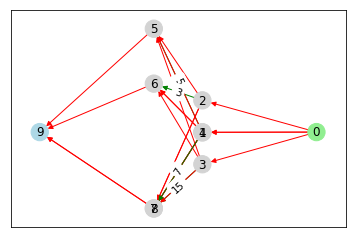

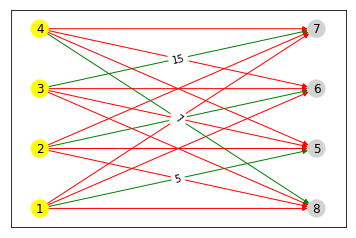

In [31]:
graph_results(totalnodes, start_nodes, end_nodes, cost, munkres_res)

### Linear Sum Assignment 


Google's OR Tools linear_assignment finds the minimum-cost perfect assignment in the given graph with integral edge weights set. The algorithm formulates the assignment problem to minimum-cost flow problem and solve it using push-relabel method. 

 The running time is O(n*m*log(nC)) where n is the number of nodes, m is the number of edges, and C is the largest magnitude of an edge cost. In principle it can be worse than the Hungarian algorithm but we don't know of any class of problems where that actually happens. 

In [32]:
from ortools.graph import pywrapgraph
start_time = time.clock()

In [33]:
cost = costs[1:len(costs)-1] # exclude source and sink nodes 

def linear_sum_solve(cost, rows, cols):
    start_time = time.clock()
    # cost is a matrix
    # rows is no of pickups
    # cols is no of drivers 
    assignment = pywrapgraph.LinearSumAssignment()
    optimal_list = []

    for worker in range(rows):
        for task in range(cols):
            if cost[worker][task]:
                assignment.AddArcWithCost(worker, task, cost[worker][task])
            
    solve_status = assignment.Solve()
    if solve_status == assignment.OPTIMAL:
        #print('Total cost = ', assignment.OptimalCost())
        for i in range(assignment.NumNodes()):
            #print('Worker %d assigned to task %d.  Cost = %d' % (
            #  i + 1,
            #    assignment.RightMate(i) + drivers + 1,
            #    assignment.AssignmentCost(i)))
            optimal_list.append((i + 1, assignment.RightMate(i) + drivers + 1))
    elif solve_status == assignment.INFEASIBLE:
        print()
        #print('No assignment is possible.')
    elif solve_status == assignment.POSSIBLE_OVERFLOW:
        print()
        #print('Some input costs are too large and may cause an integer overflow.')
    t = time.clock() - start_time
    #print("Time =", t, "seconds")
    return t, optimal_list 

linsum_time, linsum_res = linear_sum_solve(cost, pickups, drivers)
cost = [c for cost in costs for c in cost] # flatten cost matrix

<img src="linsumres.png">

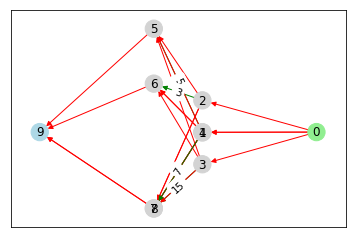

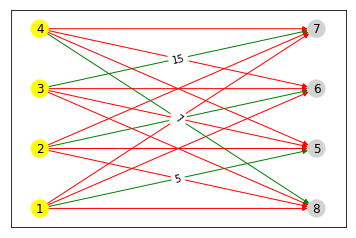

In [34]:
graph_results(totalnodes, start_nodes, end_nodes, cost, linsum_res)

### Minimum Cost Flow

Google OR Tools provides another solver to handle a larger class of problems, including the assignment problem. The code below solves a formulation of the assignment problem as max cut min flow problem.

As outlined at the beginning of the report,  the capacity of each edge would be one, the number of supply would be the number of drivers at the source. The capacity of each edge directly to the sink would also be one, with number of pick-ups at the sink. The flow-in-equals-flow-out condition forces each task to have an outflow of 1, so each pick up is assigned exactly one driver.

<img src="assignmentmincostflow.png">

In [35]:
costs = [c for cost in costs for c in cost] # flatten cost matrix 

def min_cost_solve(costs, drivers, pickups):
    start_time = time.clock()
    """Solving an Assignment Problem with MinCostFlow"""

    # Instantiate a SimpleMinCostFlow solver.
    min_cost_flow = pywrapgraph.SimpleMinCostFlow()
    
    #costs = [c for cost in costs for c in cost] # flatten cost matrix 

    # Define an array of supplies at each node.
    # given that number of drivers always equals to number of pickups 
    supplies = [drivers]+ [0]*(drivers+pickups)+ [-pickups]
    source = 0
    sink = drivers + pickups + 1
    tasks = pickups

    # start function here 
    # Add each arc.
    for i in range(len(start_nodes)):
        min_cost_flow.AddArcWithCapacityAndUnitCost(start_nodes[i], end_nodes[i],
                                                    capacities[i], costs[i])

    # Add node supplies.
    for i in range(len(supplies)):
        min_cost_flow.SetNodeSupply(i, supplies[i])

    optimal_list = [] 

    # Find the minimum cost flow between node 0 and node 10.
    if min_cost_flow.Solve() == min_cost_flow.OPTIMAL:
        #print('Total cost = ', min_cost_flow.OptimalCost())
        for arc in range(min_cost_flow.NumArcs()):

          # Can ignore arcs leading out of source or into sink.
          if min_cost_flow.Tail(arc)!=source and min_cost_flow.Head(arc)!=sink:

            # Arcs in the solution have a flow value of 1. Their start and end nodes
            # give an assignment of worker to task.

            if min_cost_flow.Flow(arc) > 0:
                print('Driver %d assigned to pick-up %d.  Cost = %d' % (
                    min_cost_flow.Tail(arc),
                    min_cost_flow.Head(arc),
                    min_cost_flow.UnitCost(arc)))
                optimal_list.append((min_cost_flow.Tail(arc),min_cost_flow.Head(arc)))
    else:
        print()
        #print('There was an issue with the min cost flow input.')
    
    t = time.clock() - start_time
    #print("Time =", t, "seconds")
    return t, optimal_list

min_cost_time, mincost_res = min_cost_solve(costs, drivers, pickups)

Driver 1 assigned to pick-up 5.  Cost = 5
Driver 2 assigned to pick-up 6.  Cost = 3
Driver 3 assigned to pick-up 7.  Cost = 15
Driver 4 assigned to pick-up 8.  Cost = 7


<img src="mincostres.png">

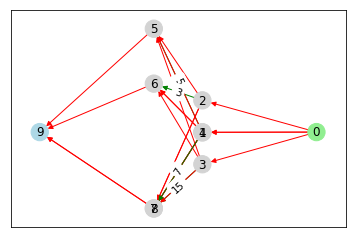

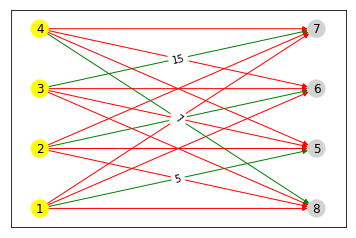

In [36]:
graph_results(totalnodes, start_nodes, end_nodes, costs, mincost_res)

## Comparison of Methods

### Time comparison

To compare the runtimes of each method, we are going to step out of our Uber pick-ups examples and consider the case where we have 250 - 5000 tasks to be assigned to same number of workers at 250 increments. At each iteration we are going to generate random data for the costs of each task, and find the optimal solutions. Then we are going to compare the runtime of each of the methods given the same data. 

In [37]:
intervals = range(500,5001,250)

In [38]:
# Run Munkres, Linear Sum Assignment and Minimal Cost for each n = 1*250,2*250,3*250,.... 
m_times = []
ls_times = []
mc_times = []

def compare():
    
    for n in intervals:
        start_nodes, end_nodes, capacities, costs  = generate_data(n+2, n,n)
        #print(costs)
        m_time, m_res = munkres_solve(costs)
        #print(m_time)
        cost = costs[1:len(costs)-1]
        ls_time, lm_res = linear_sum_solve(cost,n,n)
        #print(ls_time)
        costs = [c for cost in costs for c in cost]
        mc_time, mc_res = min_cost_solve(costs,n,n)
        #print(mc_time)
        m_times.append(m_time)
        ls_times.append(ls_time)
        mc_times.append(mc_time)

In [39]:
compare()

In [40]:
import pandas as pd 
time_df = pd.DataFrame({'Munkres': m_times, 'Linear Sum': ls_times, 'Minimal Cost': mc_times})
time_df

,Munkres,Linear Sum,Minimal Cost
0,2.799332,0.129285,0.000461
1,5.734856,0.282750,0.000650
2,11.902280,0.484863,0.000739
3,19.872023,0.762199,0.000919
4,24.801261,1.125134,0.001093
5,27.644691,1.532223,0.001228
6,37.793939,1.989127,0.001352
7,56.129625,2.556916,0.001509
8,60.278661,3.137268,0.001725
9,83.466336,3.766980,0.001821


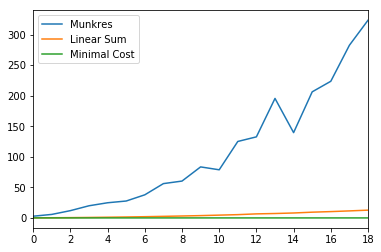

In [41]:
lines = time_df.plot.line()

## Results

- From our plot it is apparent that The Minimal Cost solver is the fastest, followed very closely by the Linear Sum Assignment solver, but we can see the minimal cost solver scales better. 

- Interestingly Google OR tools mentioned that linear assignment solver is more efficient in handling assignment problems in general - in future works it might be helpful to look into how the formulation of this project's assignment problem might have caused this observation. 

- The comparison confirms the research I've done that Munkres' algorithm is the least efficient, as it scales much worse than the other two. 

## Other Considerations

 - ***Non-Uniqueness of Assignments***: After looking at the optimal solutions for differing number of nodes, we notice that the assignments from one method to another may differ despite achieving the same minimal cost value. This might be expected due to the overconstraint of the problem and the different implementations of the packages.

 - ***Randomness of Data***: Depending on how the data is structured, given the same data, the problem might be harder to solve for one method than the other. A more robust approach when comparing the runtimes would be to take the average of several random data generations. 
 
 Another interesting observation is that when the costs tend to have duplicates, the optimal value tends to have more duplicate solutions. For example, when I generated 100 nodes with costs between 1 and 10 for each node, the minimum value almost always is 100, because it is always likely that a node must have 1 as the cost in one of its 100 edges.
 
 A more realistic approach would be using real world data and formulating the problem to a narrower scope. Then, we can try to answer the questions on why do different methods give different optimal solutions, and how so.

- ***Unequal number of tasks and workers***: This project solves the case where the number of Uber drivers match the number of pick-ups, which, are not very depictive of the reality. Often, there are more pick-ups in than drivers could satisfy, which could lead to opportunities for surge pricing. In this case we modify the supplies from source node to be the number of drivers, and we would have some nodes unvisited.

## Concluding Remarks 

As mentioned above, the project has much room of improvements as it is only a brief survey of possible methods to the assignment problem. The particular application that I picked has many more subtle edge cases that should be explored, as some pointed out above, before applying the approach to real life data.

As somebody who likes data analysis and coding, I had a lot of fun working on this project! I have been coding in Python but learning how to use networkx to create graphs visualizations and exploring optimization packages were a lot of fun. Moreover, the project gave me insights on how would I start looking at problems through a mathematician's perspective. This class has been one of my most enjoyable classes at UCLA - it excites me to able to apply mathematics to solve interesting problems efficiently and rigorously. 

## Sources

- https://www.joshmeetscomputer.com/bipartite-projected/
- http://csclab.murraystate.edu/~bob.pilgrim/445/munkres.html
- http://software.clapper.org/munkres/
- https://developers.google.com/optimization/assignment/simple_assignment
- https://developers.google.com/optimization/assignment/assignment_min_cost_flow